# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')
from sklearn.preprocessing import LabelEncoder
import importlib
import hw2code

import warnings
warnings.filterwarnings('ignore')

# дополнительные import
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0)
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

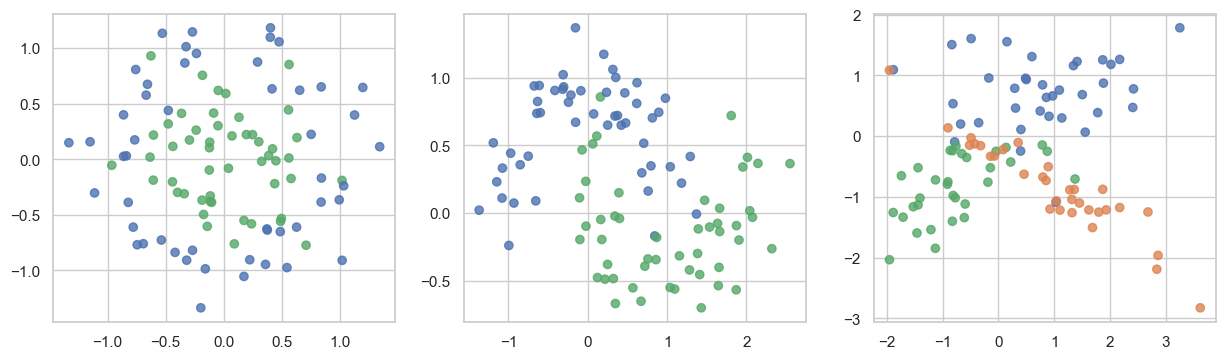

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [16]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)
    plt.show()


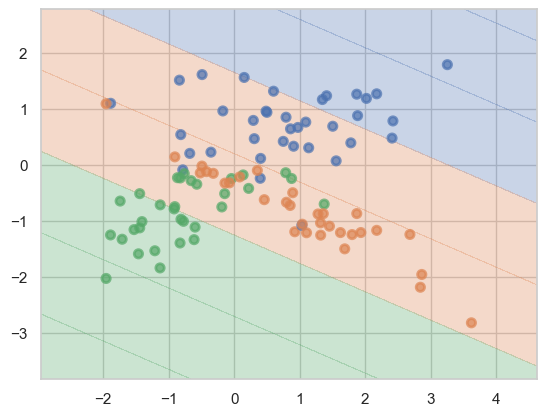

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

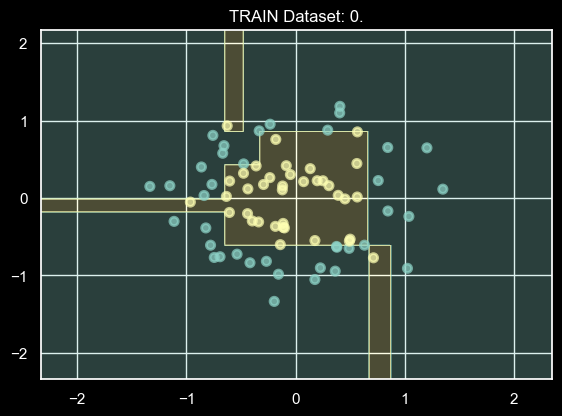

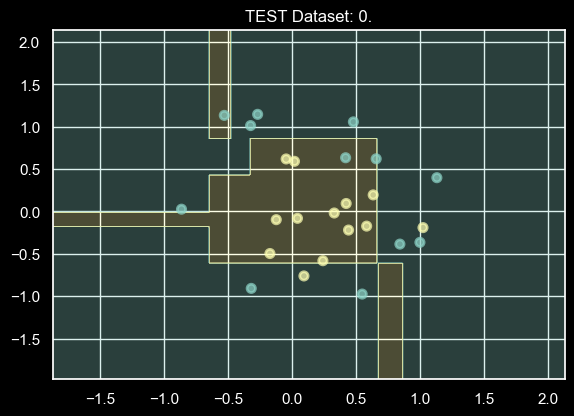

Train accuracy: 1.000.
Test accuracy 0.800.
Difference: 0.200


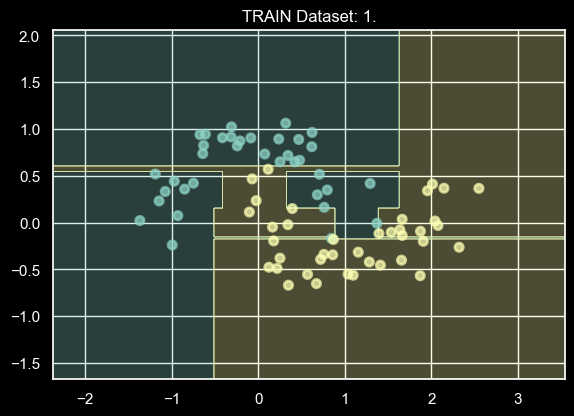

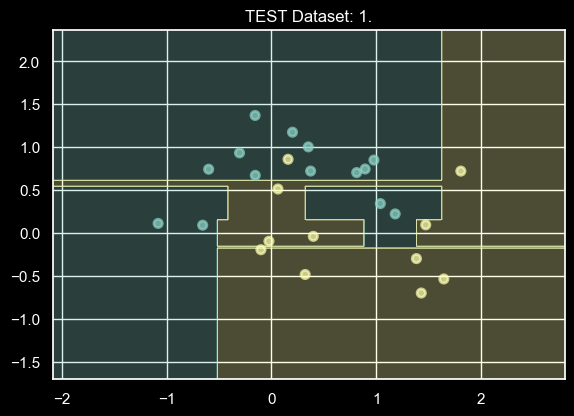

Train accuracy: 1.000.
Test accuracy 0.960.
Difference: 0.040


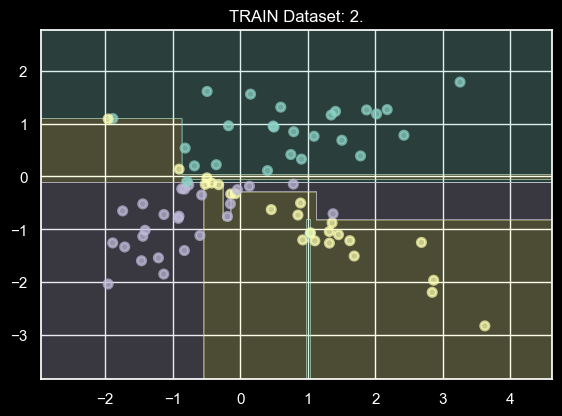

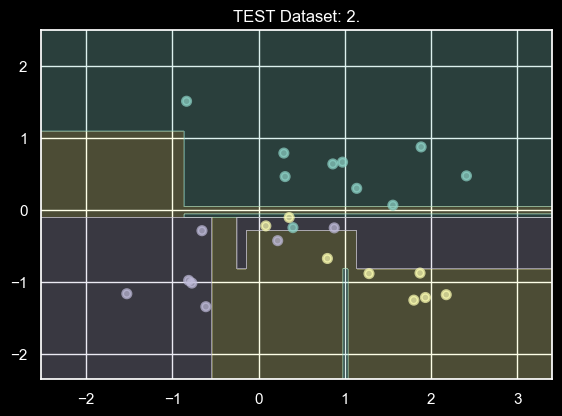

Train accuracy: 1.000.
Test accuracy 0.840.
Difference: 0.160


In [17]:
for dataset_index, (feature_matrix, target_vector) in enumerate(datasets):

    x_train, x_test, y_train, y_test = train_test_split(feature_matrix, target_vector)

    tree = DecisionTreeClassifier()

    tree.fit(x_train, y_train)

    plt.title(f'TRAIN Dataset: {dataset_index}.')

    plot_surface(tree, x_train, y_train)

    plt.title(f'TEST Dataset: {dataset_index}.')

    plot_surface(tree, x_test, y_test)

    train_prediction = tree.predict(x_train)

    train_accuracy = accuracy_score(y_train, train_prediction)

    test_prediction = tree.predict(x_test)

    test_accuracy = accuracy_score(y_test, test_prediction)

    print(f'Train accuracy: {train_accuracy:.3f}.\nTest accuracy {test_accuracy:.3f}.')

    print(f"Difference: {train_accuracy - test_accuracy:.3f}")

__Ответ:__ деревья переобучились, поскольку на тренировочной выборке их accuracy = 1.0, а на тестовой - значительно ниже этих значений.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

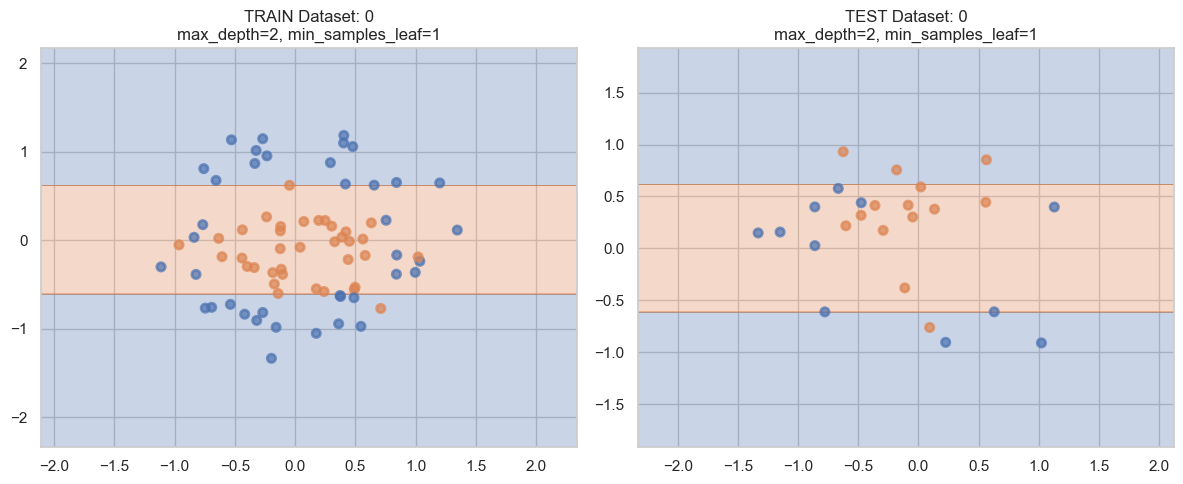

Dataset: 0, max_depth: 2, min_samples_leaf: 1
Train accuracy: 0.853
Test accuracy: 0.480
Difference: 0.373


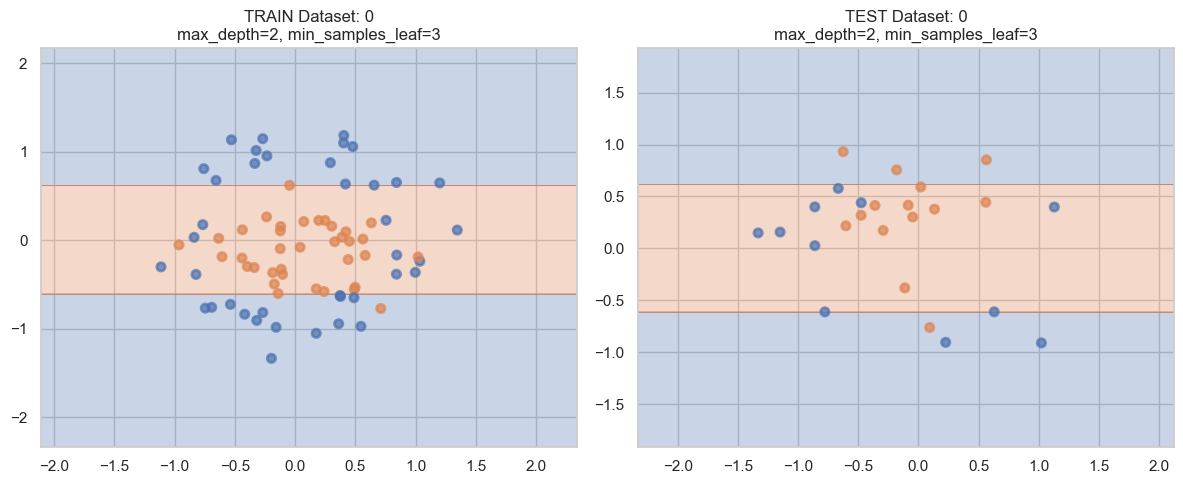

Dataset: 0, max_depth: 2, min_samples_leaf: 3
Train accuracy: 0.853
Test accuracy: 0.480
Difference: 0.373


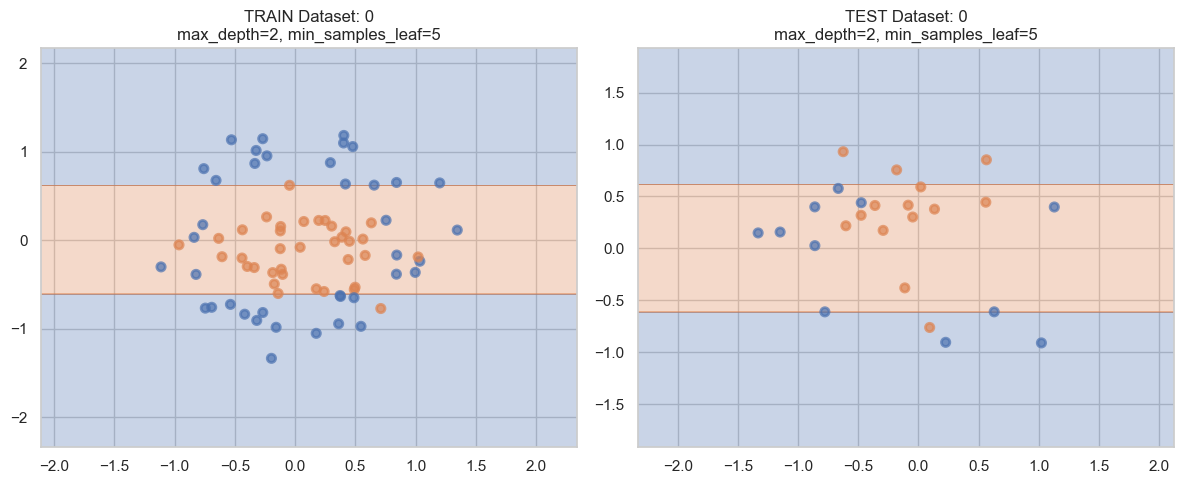

Dataset: 0, max_depth: 2, min_samples_leaf: 5
Train accuracy: 0.853
Test accuracy: 0.480
Difference: 0.373


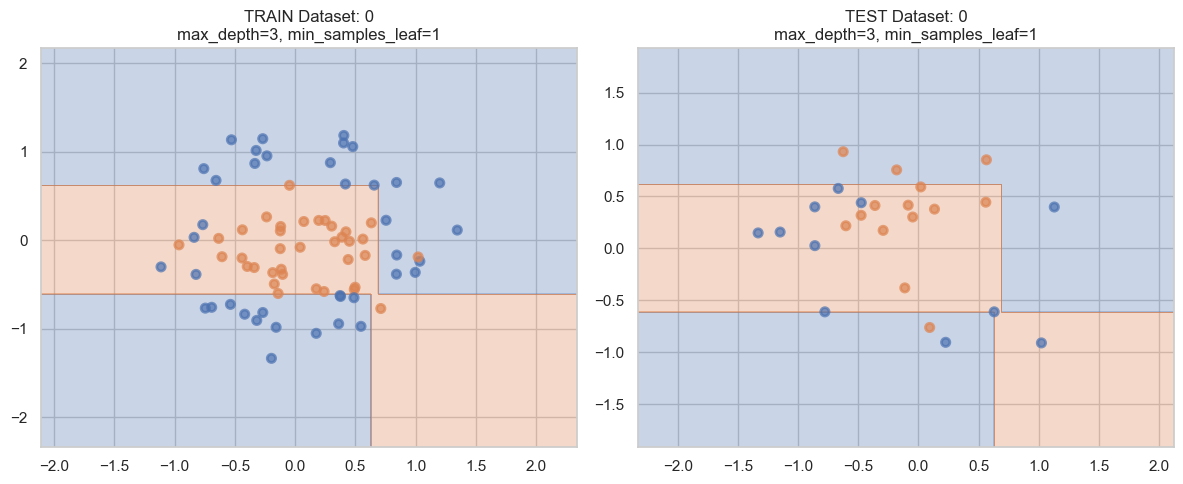

Dataset: 0, max_depth: 3, min_samples_leaf: 1
Train accuracy: 0.933
Test accuracy: 0.480
Difference: 0.453


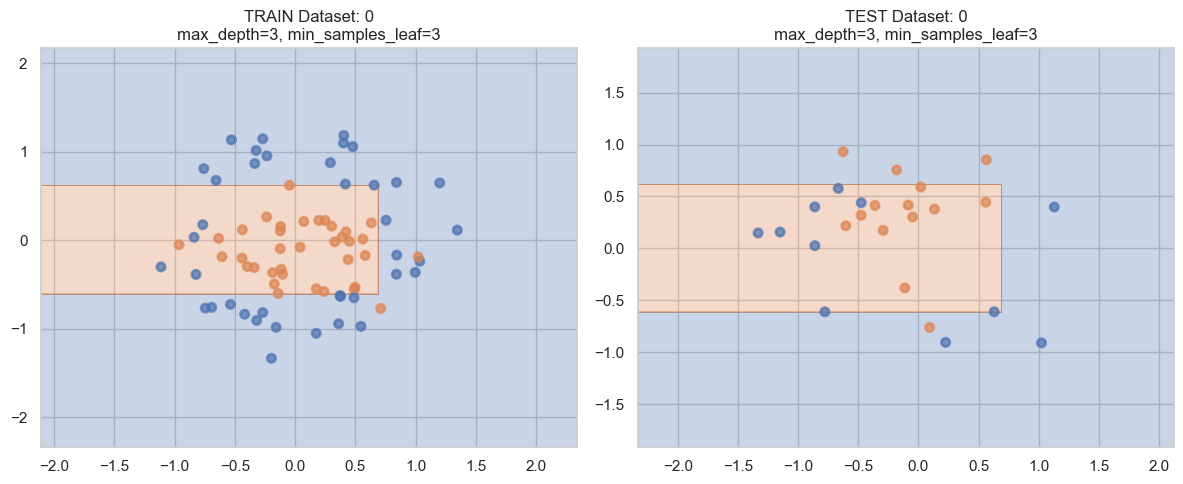

Dataset: 0, max_depth: 3, min_samples_leaf: 3
Train accuracy: 0.920
Test accuracy: 0.520
Difference: 0.400


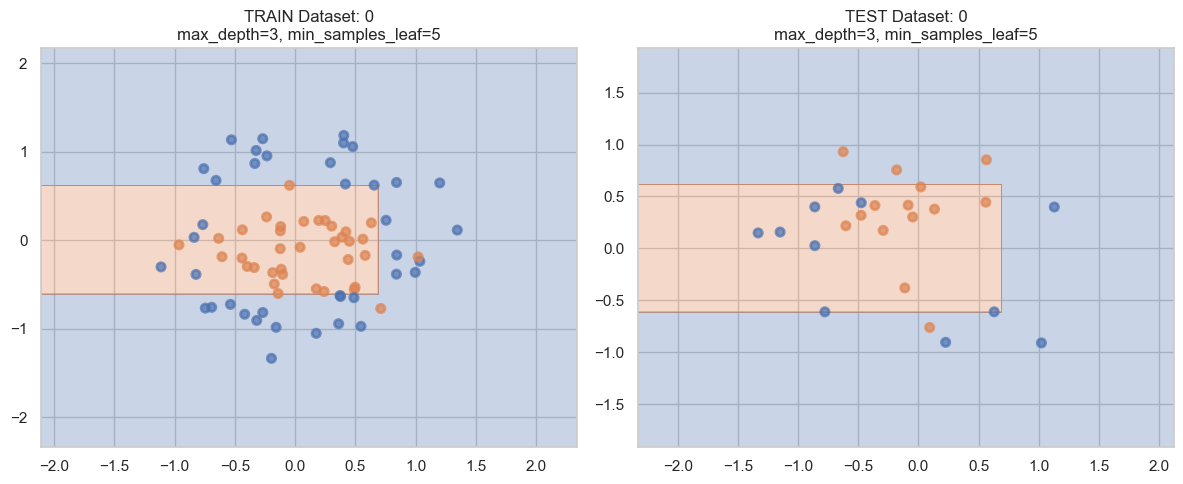

Dataset: 0, max_depth: 3, min_samples_leaf: 5
Train accuracy: 0.920
Test accuracy: 0.520
Difference: 0.400


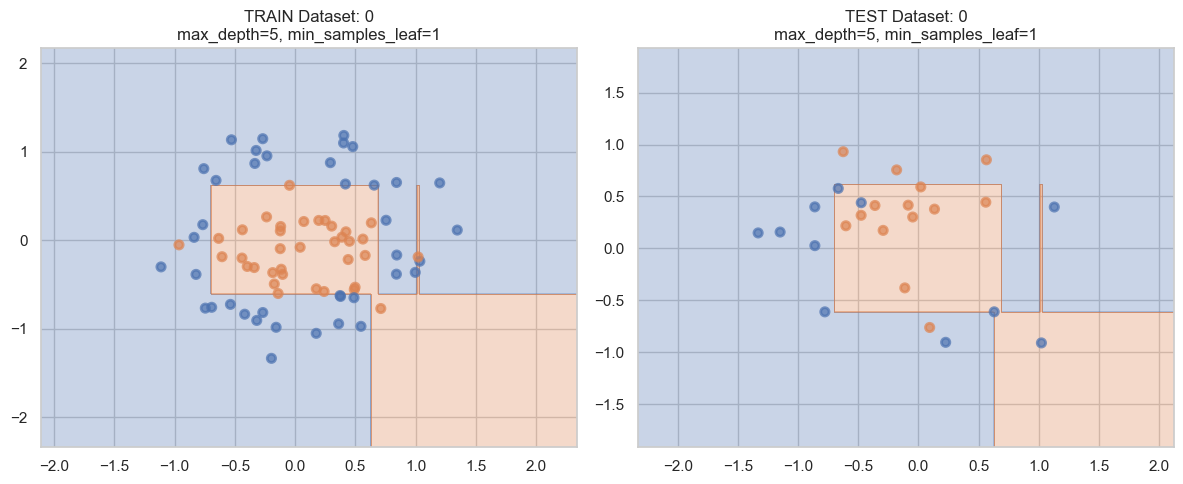

Dataset: 0, max_depth: 5, min_samples_leaf: 1
Train accuracy: 0.987
Test accuracy: 0.680
Difference: 0.307


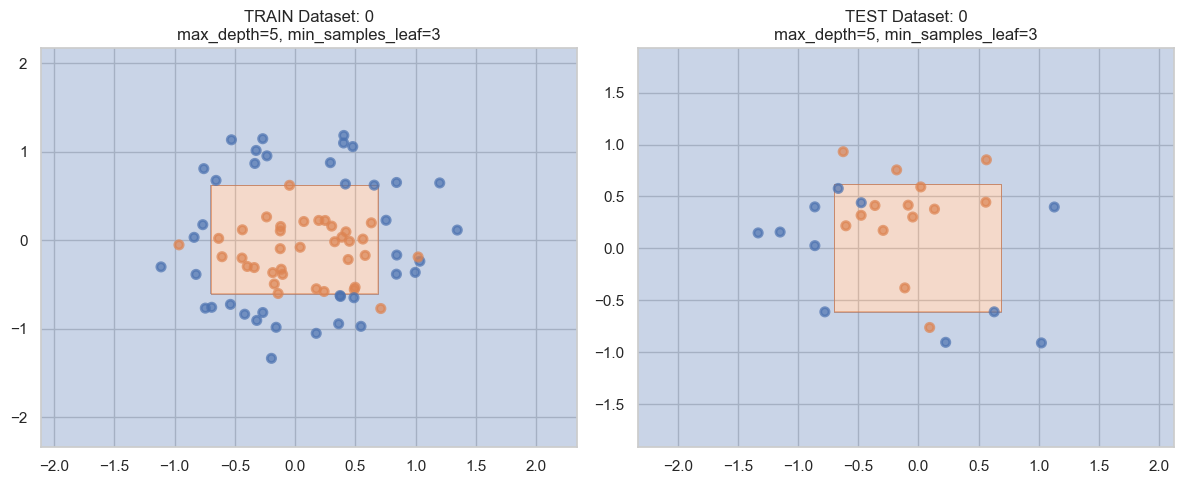

Dataset: 0, max_depth: 5, min_samples_leaf: 3
Train accuracy: 0.960
Test accuracy: 0.720
Difference: 0.240


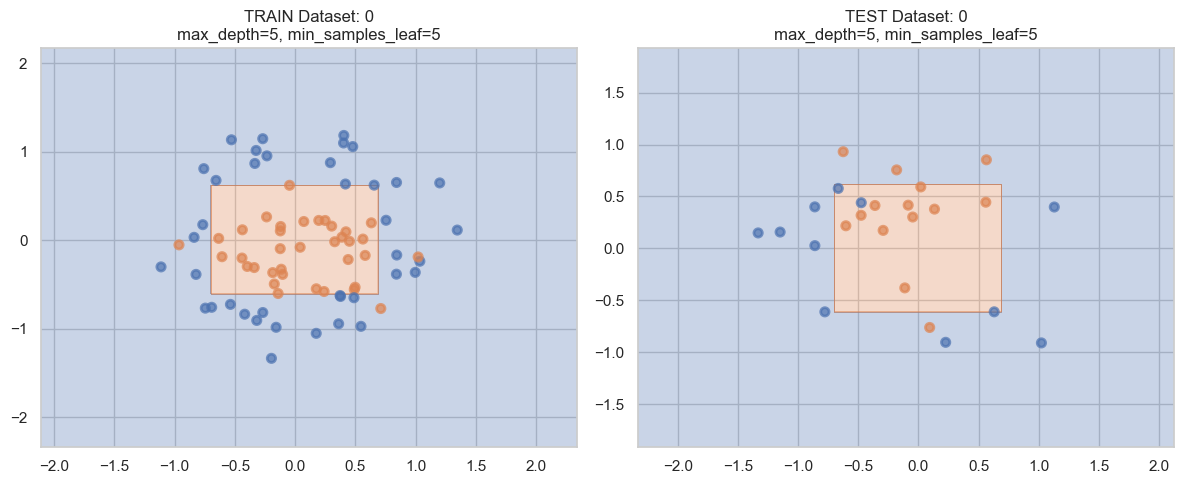

Dataset: 0, max_depth: 5, min_samples_leaf: 5
Train accuracy: 0.960
Test accuracy: 0.720
Difference: 0.240


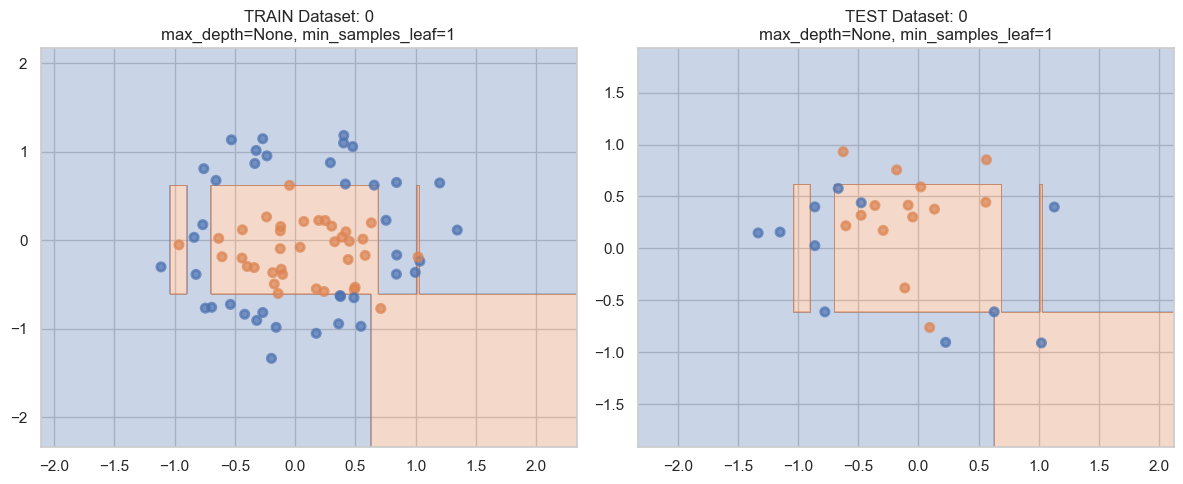

Dataset: 0, max_depth: None, min_samples_leaf: 1
Train accuracy: 1.000
Test accuracy: 0.680
Difference: 0.320


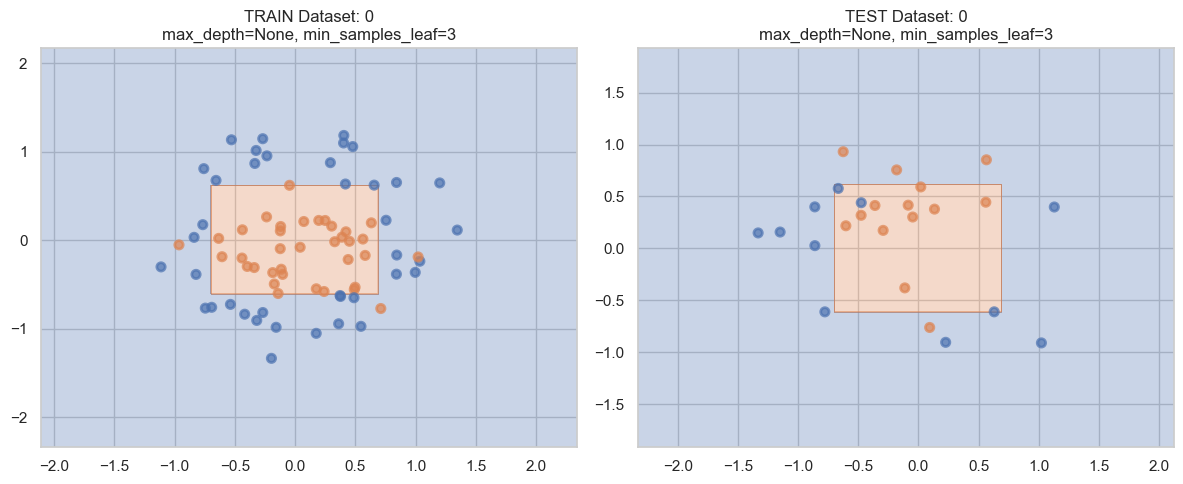

Dataset: 0, max_depth: None, min_samples_leaf: 3
Train accuracy: 0.960
Test accuracy: 0.720
Difference: 0.240


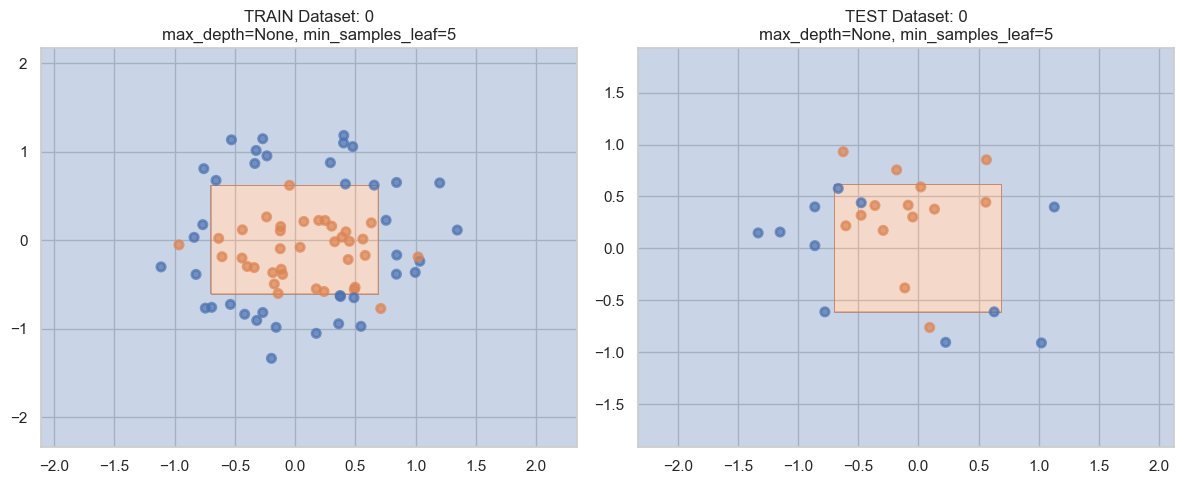

Dataset: 0, max_depth: None, min_samples_leaf: 5
Train accuracy: 0.960
Test accuracy: 0.720
Difference: 0.240


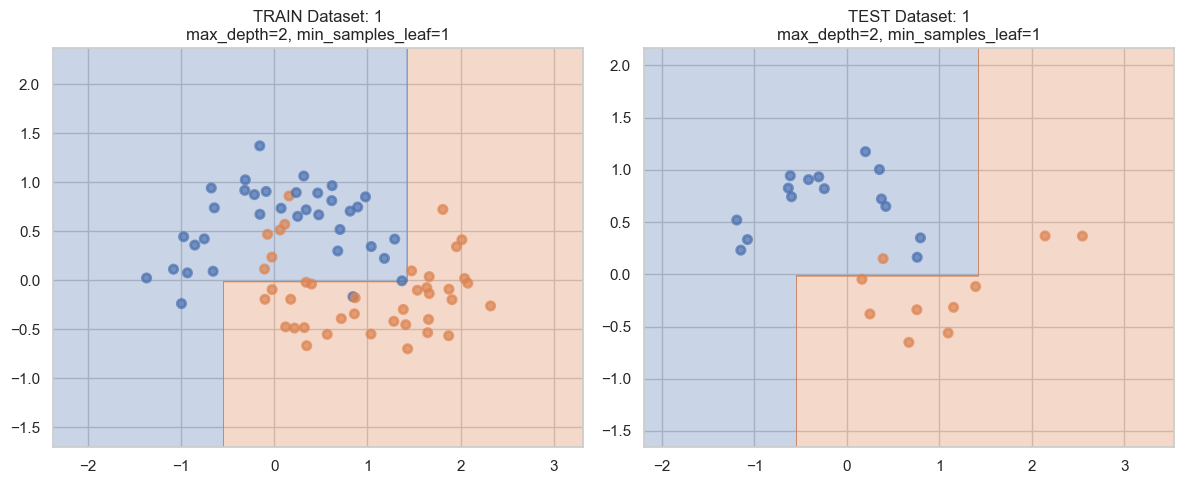

Dataset: 1, max_depth: 2, min_samples_leaf: 1
Train accuracy: 0.907
Test accuracy: 0.960
Difference: -0.053


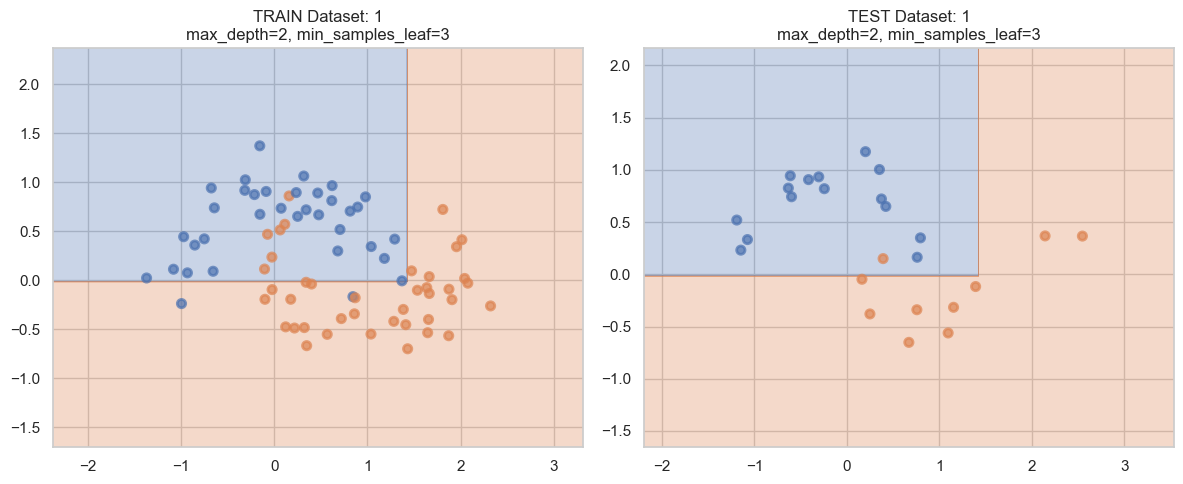

Dataset: 1, max_depth: 2, min_samples_leaf: 3
Train accuracy: 0.893
Test accuracy: 0.960
Difference: -0.067


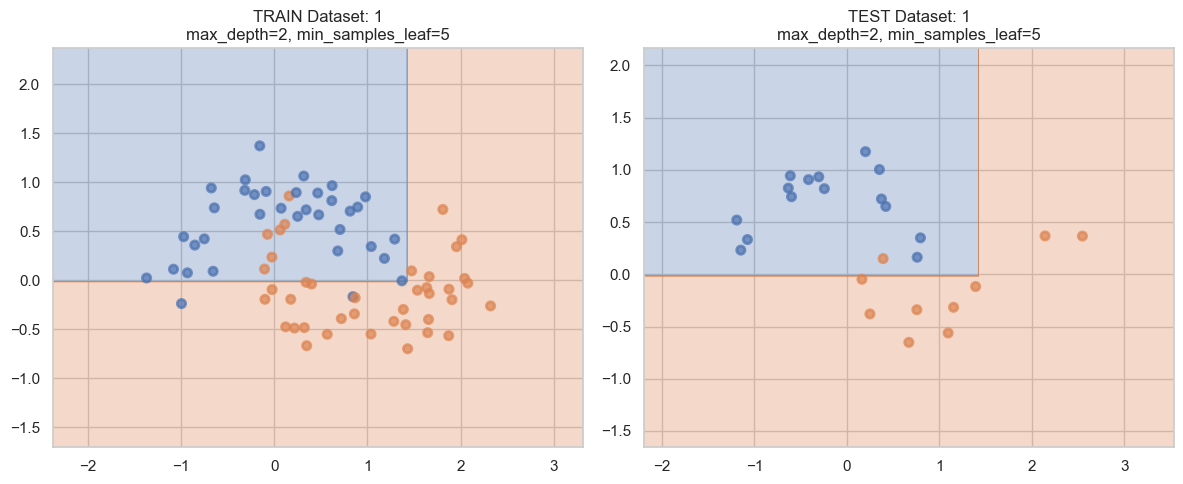

Dataset: 1, max_depth: 2, min_samples_leaf: 5
Train accuracy: 0.893
Test accuracy: 0.960
Difference: -0.067


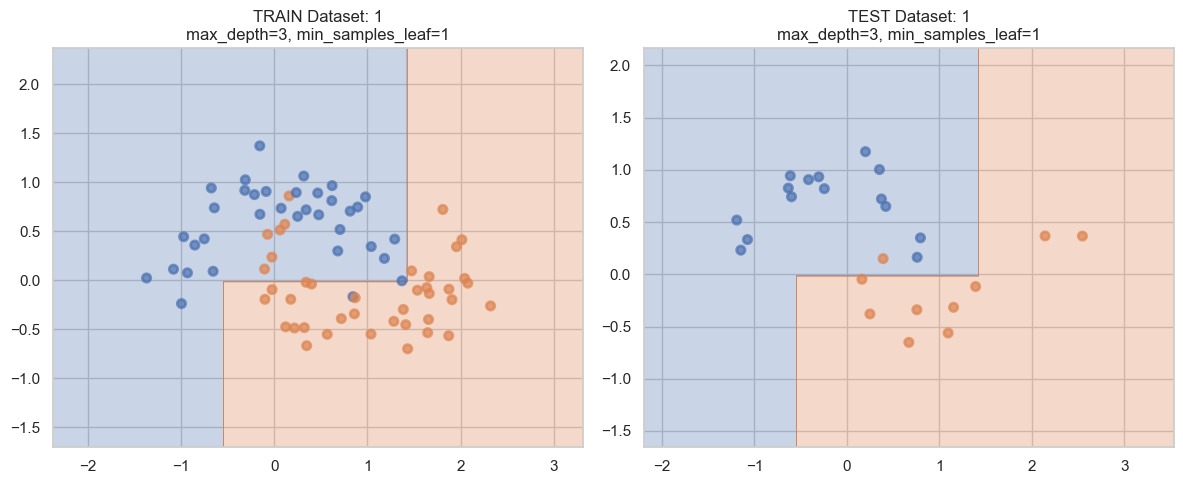

Dataset: 1, max_depth: 3, min_samples_leaf: 1
Train accuracy: 0.907
Test accuracy: 0.960
Difference: -0.053


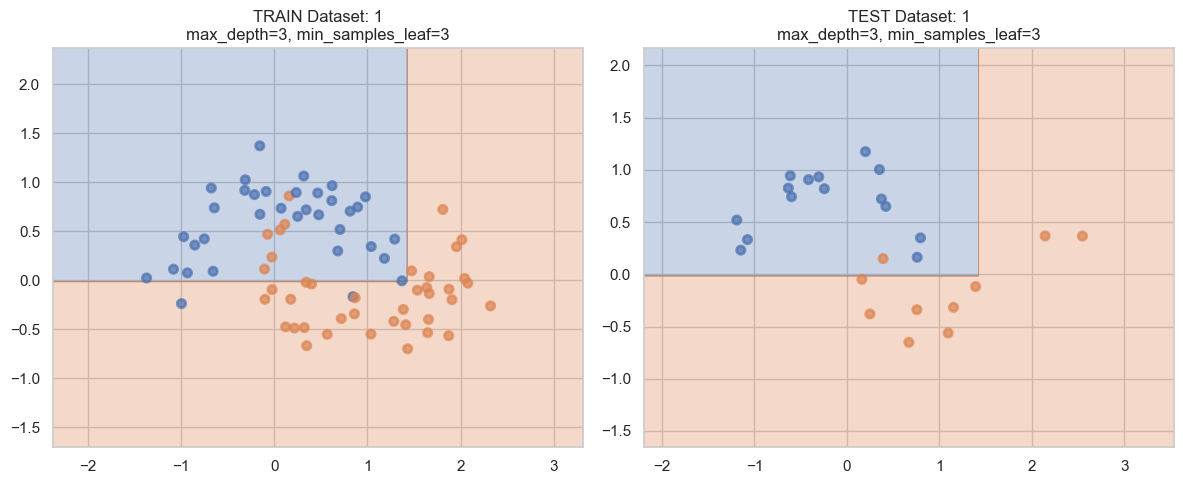

Dataset: 1, max_depth: 3, min_samples_leaf: 3
Train accuracy: 0.893
Test accuracy: 0.960
Difference: -0.067


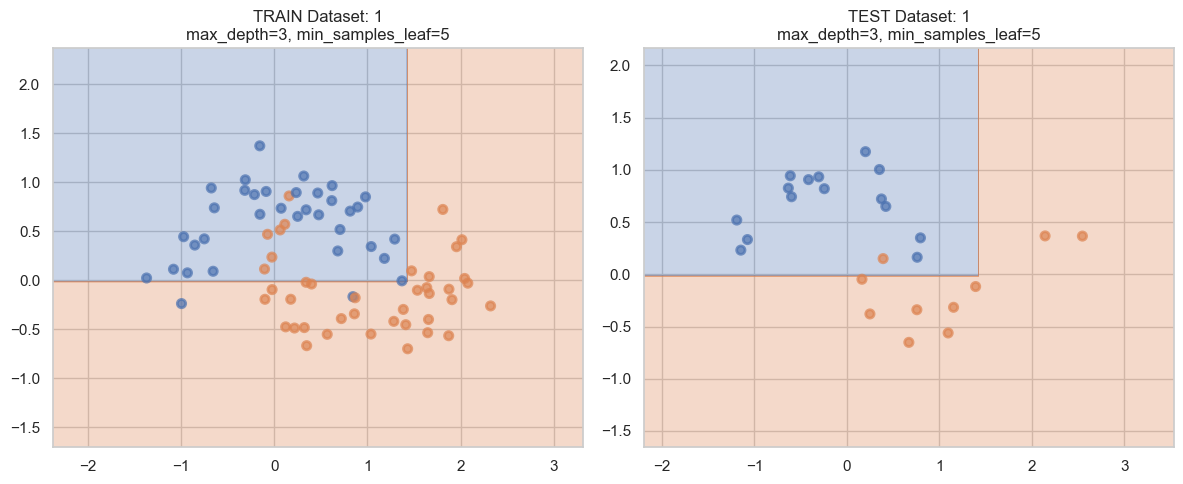

Dataset: 1, max_depth: 3, min_samples_leaf: 5
Train accuracy: 0.893
Test accuracy: 0.960
Difference: -0.067


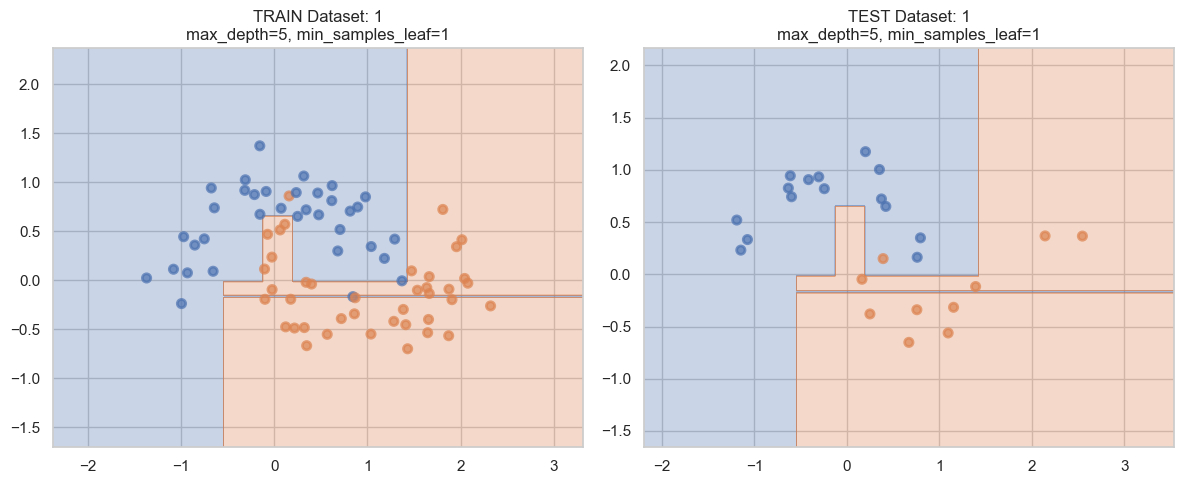

Dataset: 1, max_depth: 5, min_samples_leaf: 1
Train accuracy: 0.987
Test accuracy: 0.960
Difference: 0.027


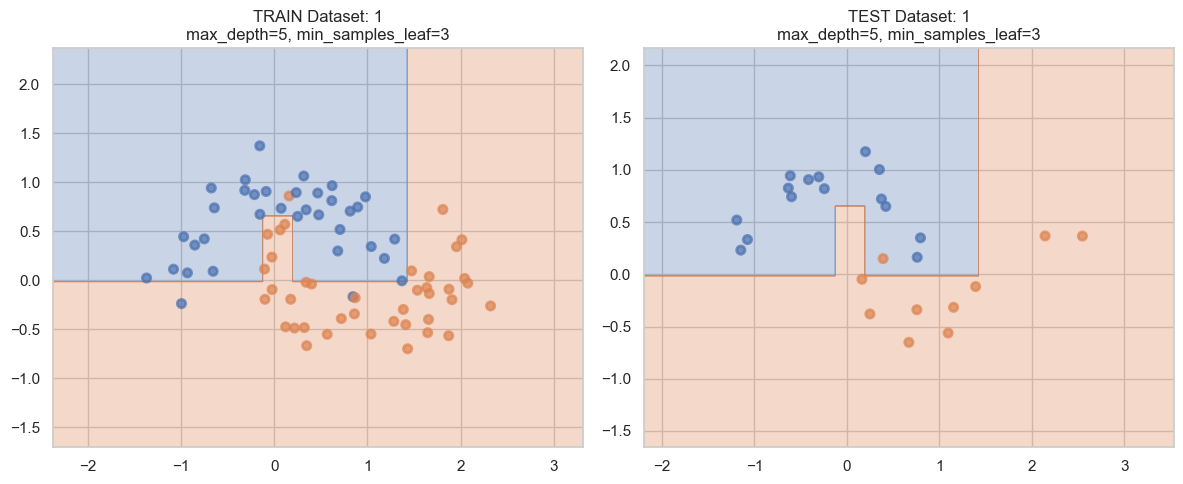

Dataset: 1, max_depth: 5, min_samples_leaf: 3
Train accuracy: 0.960
Test accuracy: 0.960
Difference: 0.000


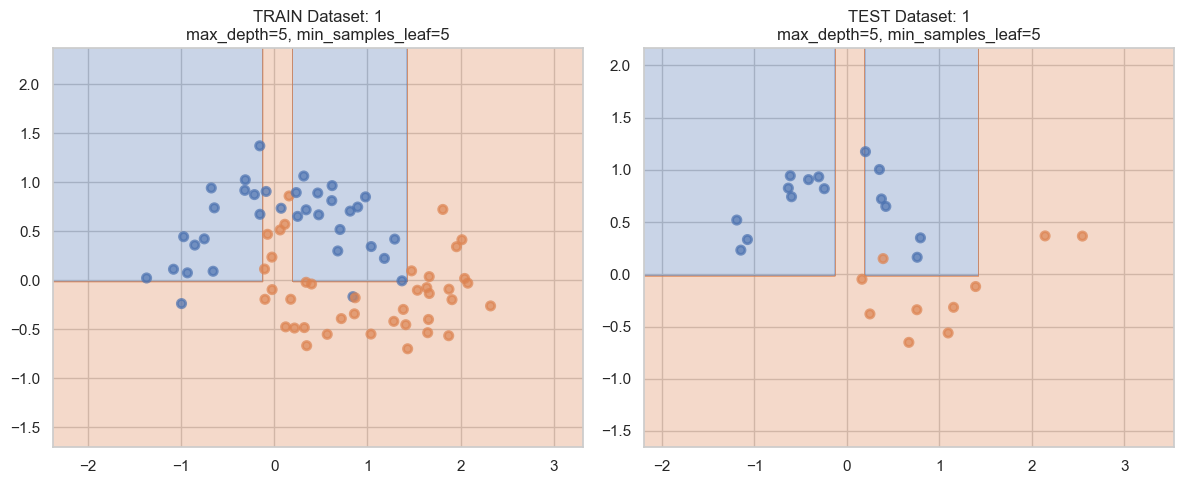

Dataset: 1, max_depth: 5, min_samples_leaf: 5
Train accuracy: 0.947
Test accuracy: 0.960
Difference: -0.013


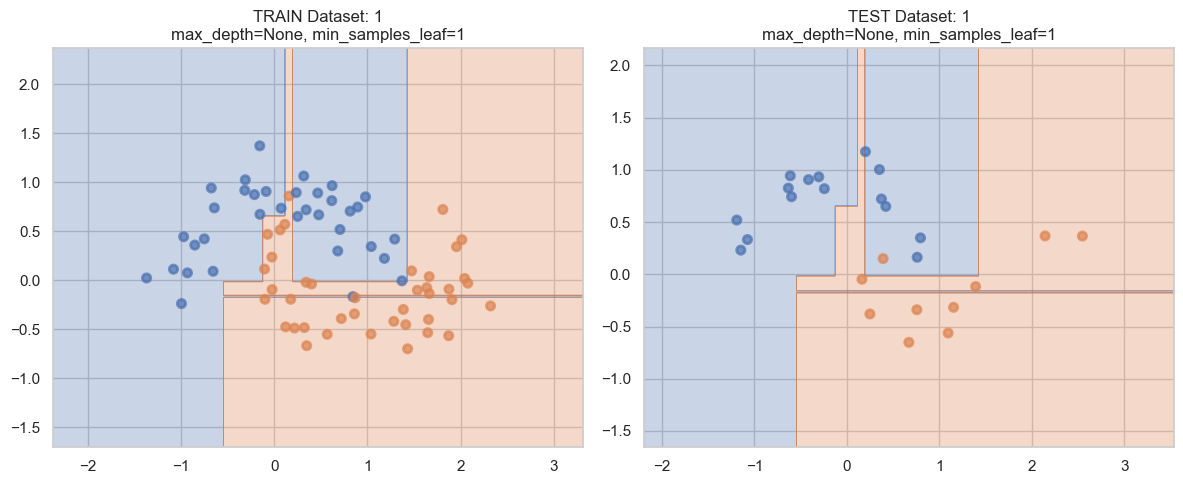

Dataset: 1, max_depth: None, min_samples_leaf: 1
Train accuracy: 1.000
Test accuracy: 0.960
Difference: 0.040


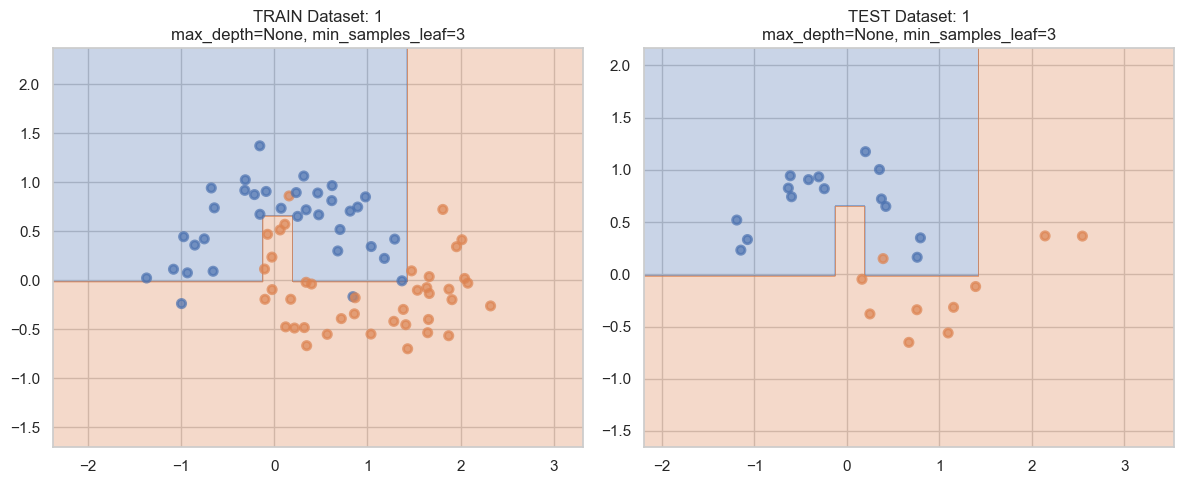

Dataset: 1, max_depth: None, min_samples_leaf: 3
Train accuracy: 0.960
Test accuracy: 0.960
Difference: 0.000


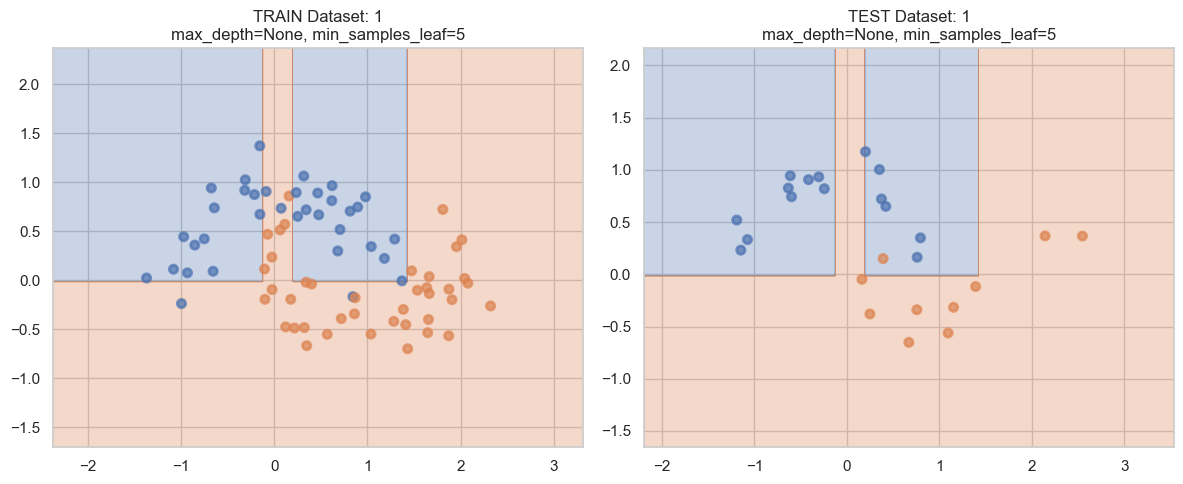

Dataset: 1, max_depth: None, min_samples_leaf: 5
Train accuracy: 0.947
Test accuracy: 0.960
Difference: -0.013


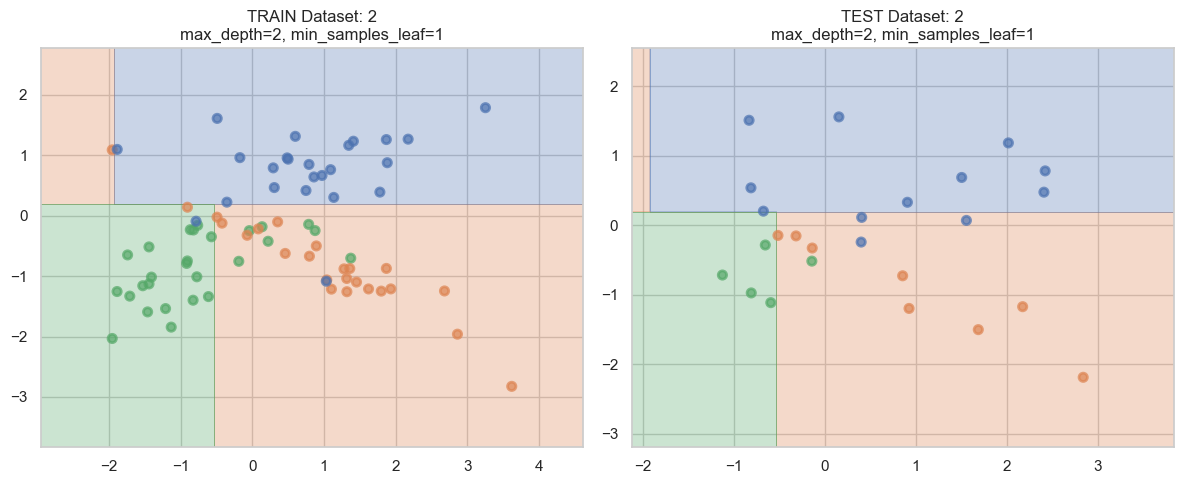

Dataset: 2, max_depth: 2, min_samples_leaf: 1
Train accuracy: 0.867
Test accuracy: 0.840
Difference: 0.027


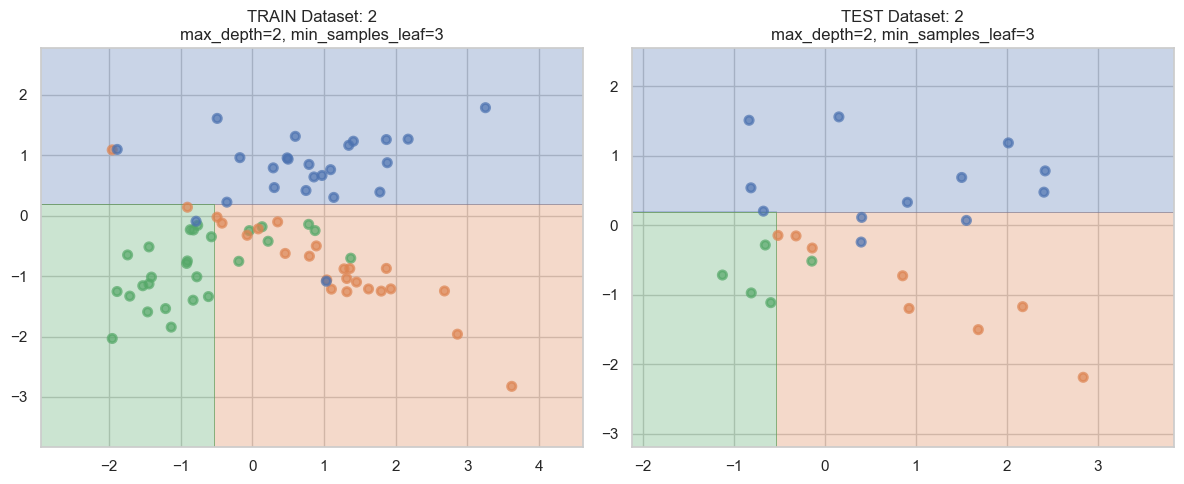

Dataset: 2, max_depth: 2, min_samples_leaf: 3
Train accuracy: 0.853
Test accuracy: 0.840
Difference: 0.013


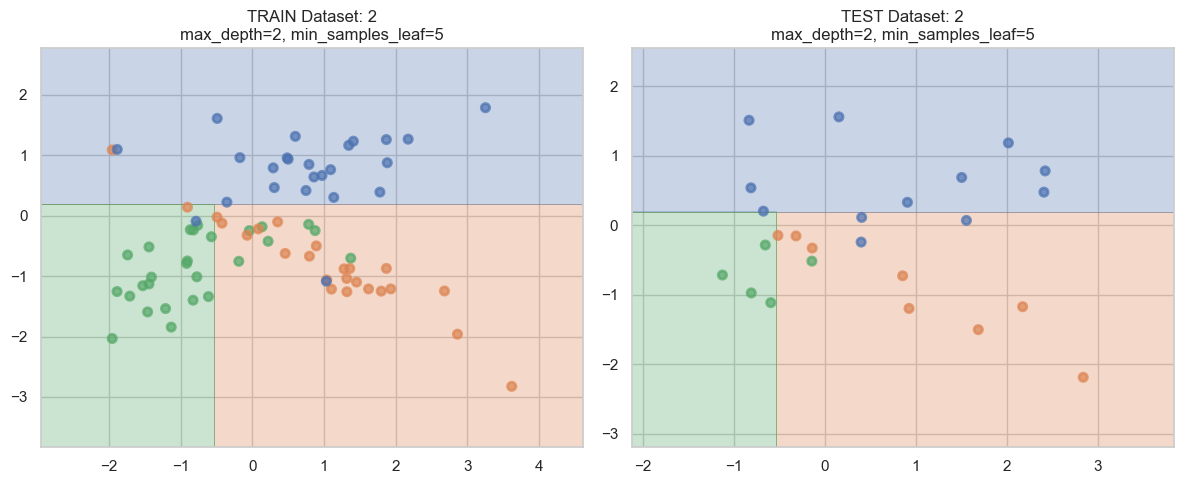

Dataset: 2, max_depth: 2, min_samples_leaf: 5
Train accuracy: 0.853
Test accuracy: 0.840
Difference: 0.013


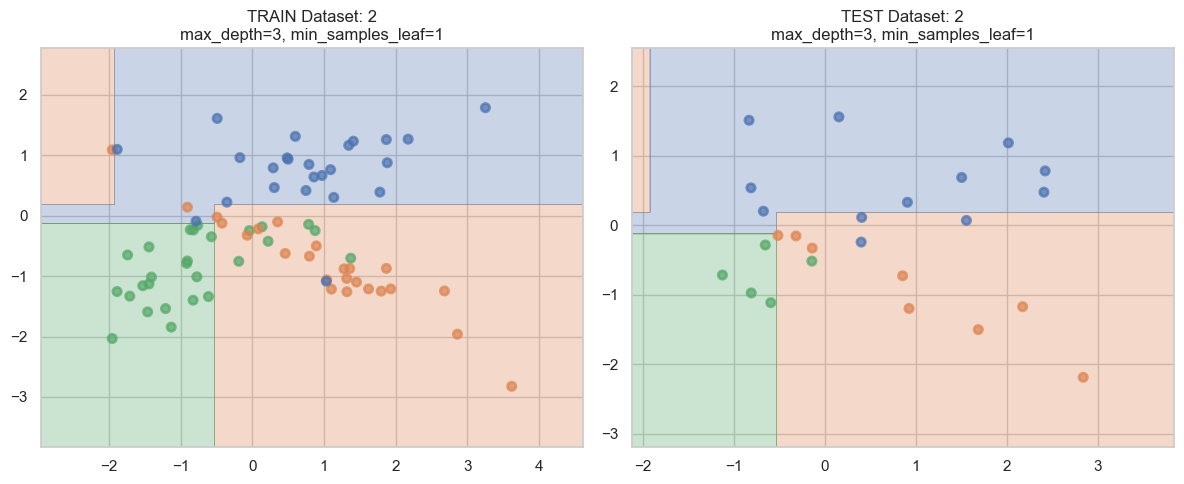

Dataset: 2, max_depth: 3, min_samples_leaf: 1
Train accuracy: 0.880
Test accuracy: 0.840
Difference: 0.040


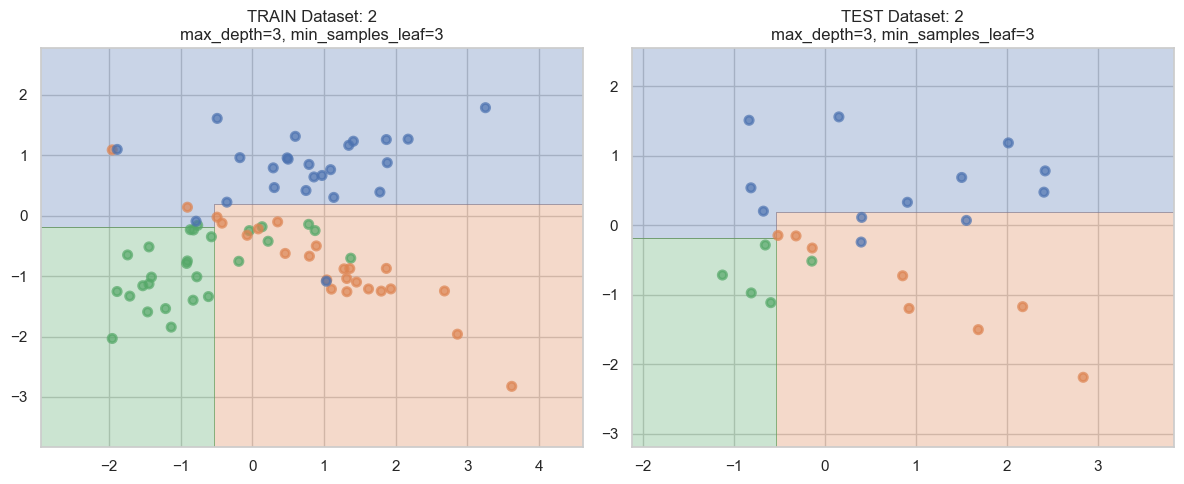

Dataset: 2, max_depth: 3, min_samples_leaf: 3
Train accuracy: 0.853
Test accuracy: 0.840
Difference: 0.013


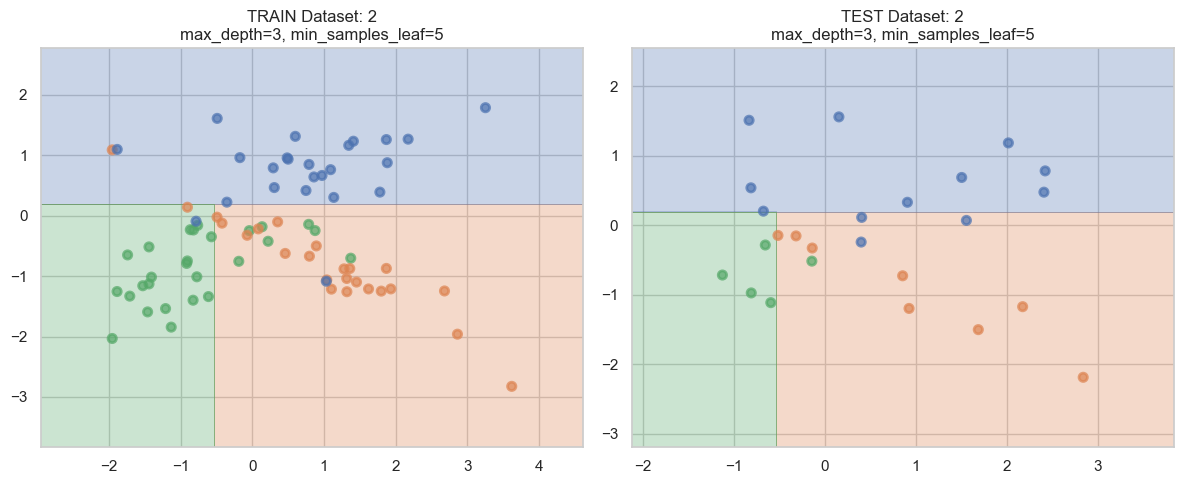

Dataset: 2, max_depth: 3, min_samples_leaf: 5
Train accuracy: 0.853
Test accuracy: 0.840
Difference: 0.013


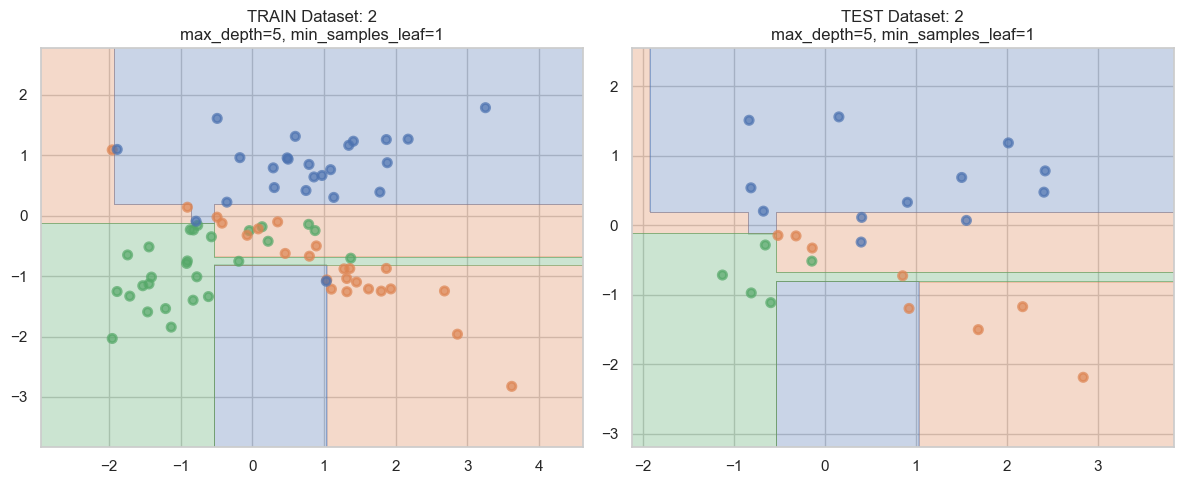

Dataset: 2, max_depth: 5, min_samples_leaf: 1
Train accuracy: 0.933
Test accuracy: 0.760
Difference: 0.173


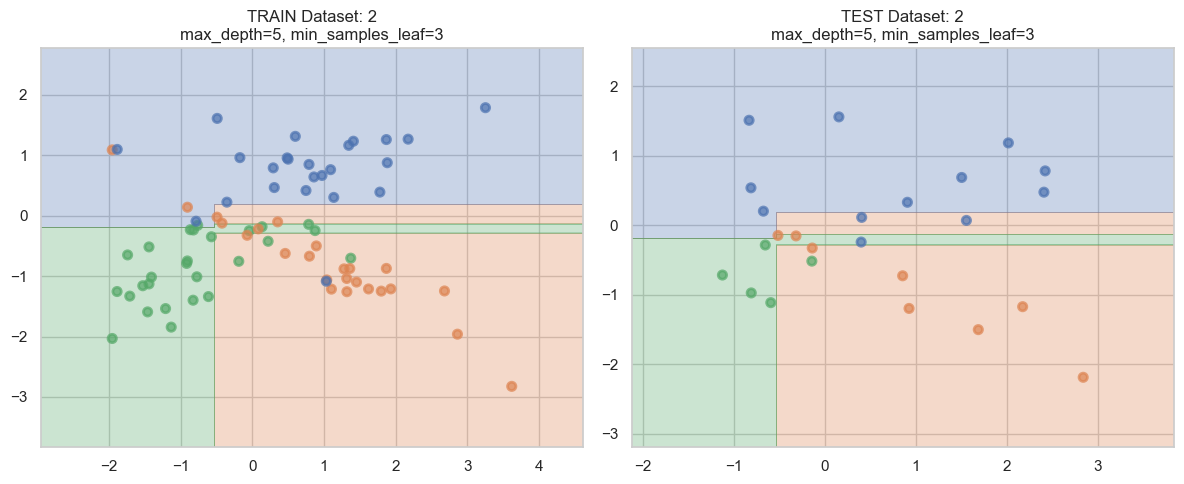

Dataset: 2, max_depth: 5, min_samples_leaf: 3
Train accuracy: 0.893
Test accuracy: 0.760
Difference: 0.133


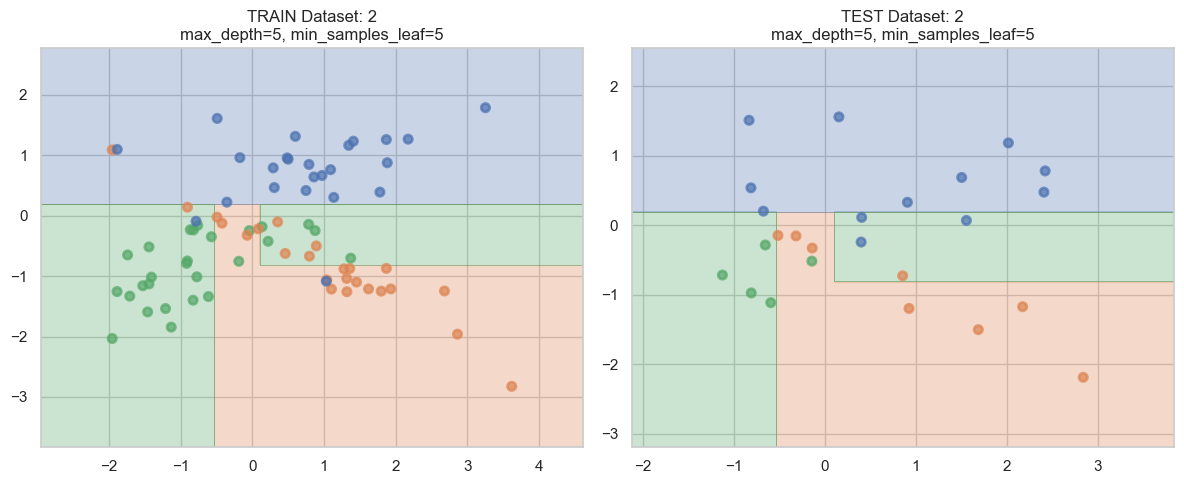

Dataset: 2, max_depth: 5, min_samples_leaf: 5
Train accuracy: 0.867
Test accuracy: 0.800
Difference: 0.067


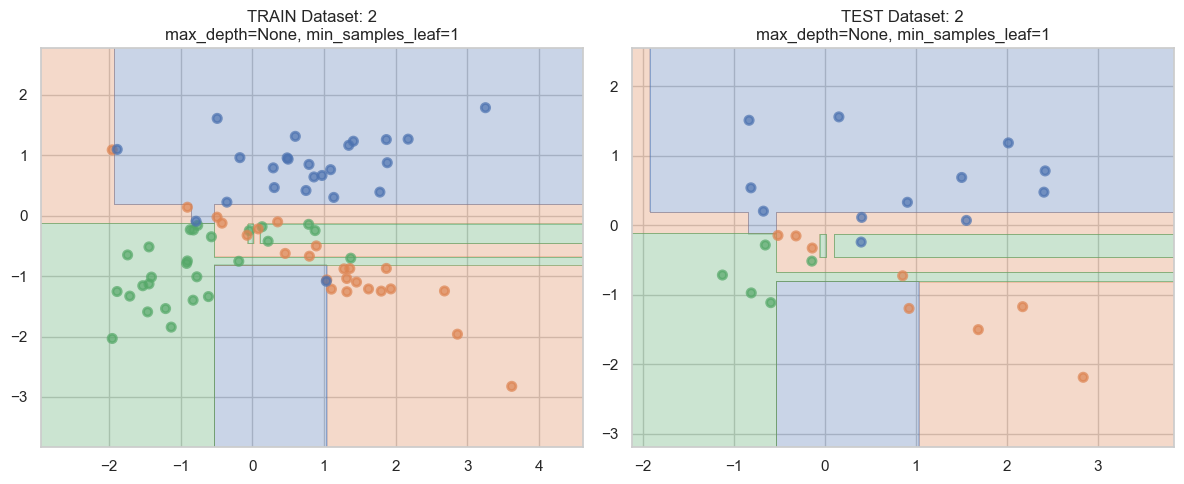

Dataset: 2, max_depth: None, min_samples_leaf: 1
Train accuracy: 1.000
Test accuracy: 0.760
Difference: 0.240


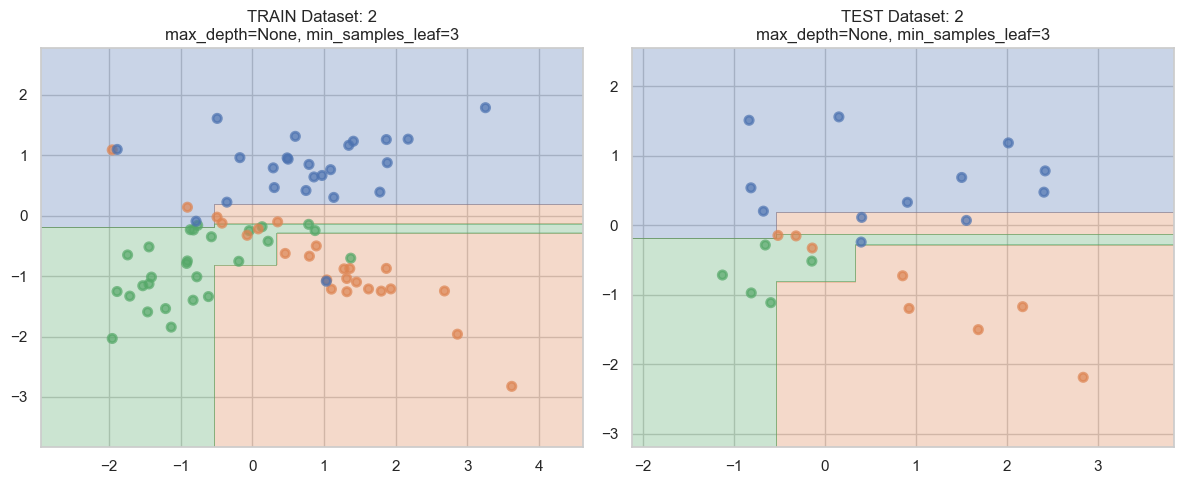

Dataset: 2, max_depth: None, min_samples_leaf: 3
Train accuracy: 0.907
Test accuracy: 0.760
Difference: 0.147


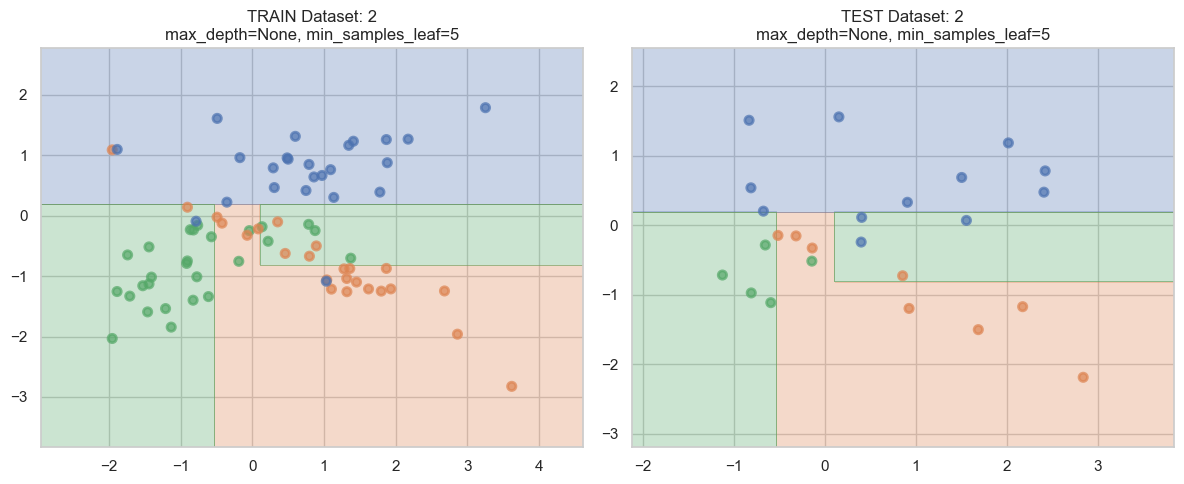

Dataset: 2, max_depth: None, min_samples_leaf: 5
Train accuracy: 0.867
Test accuracy: 0.800
Difference: 0.067


In [8]:
max_depth_list = [2, 3, 5, None]
min_samples_leaf_list = [1, 3, 5]

for dataset_index, (feature_matrix, target_vector) in enumerate(datasets):
    x_train, x_test, y_train, y_test = train_test_split(feature_matrix, target_vector)
    
    for max_depth in max_depth_list:
        for min_samples_leaf in min_samples_leaf_list:
            tree = DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
            
            tree.fit(x_train, y_train)
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            plt.sca(ax1)
            plot_surface(tree, x_train, y_train)
            plt.title(f'TRAIN Dataset: {dataset_index}\nmax_depth={max_depth}, min_samples_leaf={min_samples_leaf}')
            
            plt.sca(ax2)
            plot_surface(tree, x_test, y_test)
            plt.title(f'TEST Dataset: {dataset_index}\nmax_depth={max_depth}, min_samples_leaf={min_samples_leaf}')
            
            plt.tight_layout()
            plt.show()
            
            train_prediction = tree.predict(x_train)
            train_accuracy = accuracy_score(y_train, train_prediction)
            
            test_prediction = tree.predict(x_test)
            test_accuracy = accuracy_score(y_test, test_prediction)
            
            print(f'Dataset: {dataset_index}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}')
            print(f'Train accuracy: {train_accuracy:.3f}')
            print(f'Test accuracy: {test_accuracy:.3f}')
            print(f'Difference: {train_accuracy - test_accuracy:.3f}')

__Ответ:__ Самых лучших показателей (при минимальном различии train accuracy и test accuracy) мы достигаем при следующих ситуациях:
max_depth: None, min_samples_leaf: 3
max_depth: 5, min_samples_leaf: 3

При установленном значении max depth результаты модели более плавные, области выражены явно. 
Хороших результатов при высоком или слишком низком min samples leaf мы почти не достигаем (лучше среднее значение).
Датасеты реагируют похожим образом, поскольку настраиваемые параметры в основном влияют на само решающее дерево, и общие тенденции (влияние показателей max depth, min samples leaf) прослеживаются везде.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

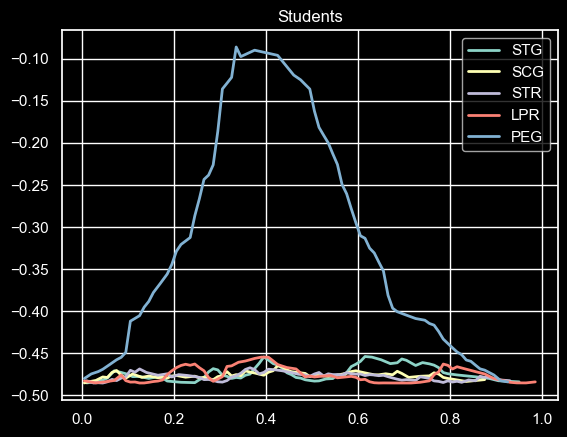

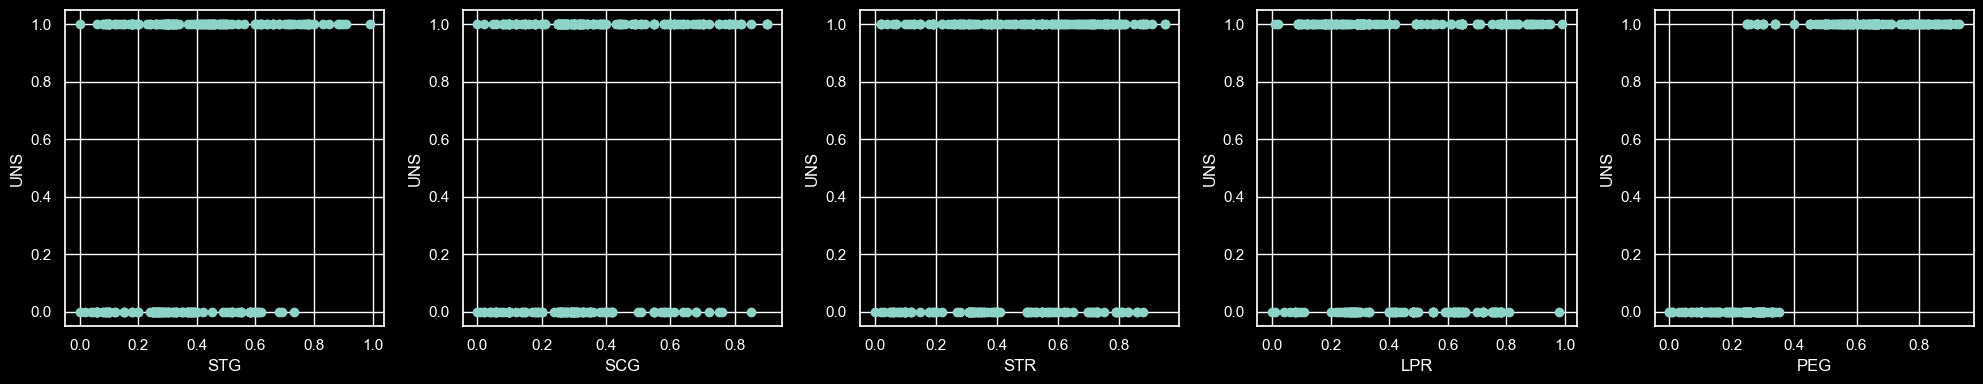

In [9]:
import hw2code
from hw2code import DecisionTree, find_best_split

students_df_path = 'datasets/students.csv'
students_df = pd.read_csv(students_df_path)

students_target = students_df['UNS']
features = students_df.columns.drop('UNS')

plt.style.use('dark_background')

for current_feature in features:

    current = students_df[current_feature]

    thresholds, ginis, threshold_best, gini_best = find_best_split(current, students_target)

    plt.plot(thresholds, ginis, label=current_feature, linewidth=2)

plt.title('Students')
plt.legend()
plt.show()


my_figure, new_ax = plt.subplots(1, 5, figsize=(20, 4))

for index, current_feature in enumerate(features):

    new_ax[index].scatter(students_df[current_feature], students_target)

    new_ax[index].set_xlabel(current_feature)
    new_ax[index].set_ylabel('UNS')
    

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Можно заметить (по кривым значений критерия Джини), что признак PEG единственный позволяет четко выделить два поддерева, в то время как другие признаки распределены хаотично, нельзя выделить порог.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [10]:
importlib.reload(hw2code)
from hw2code import DecisionTree, find_best_split

mushrooms_dataset_path = 'datasets/agaricus-lepiota.data'
mushrooms_df = pd.read_csv(mushrooms_dataset_path)
print('Mushrooms dataset:')

encoders = list()

changed_mushrooms_df = mushrooms_df.copy()
features = mushrooms_df.columns

for feature in features:
    encoder = LabelEncoder()
    encoders.append(encoder)

    changed_mushrooms_df[feature] = encoder.fit_transform(mushrooms_df[feature])


new_features = changed_mushrooms_df.iloc[:, 1:]
y_target = changed_mushrooms_df.iloc[:, 0]

x_train, x_test, y_train, y_test = train_test_split(new_features, y_target, train_size=0.5)

tree = DecisionTree(['categorical'] * new_features.shape[1])

tree.fit(x_train.values, y_train.values)

prediction = tree.predict(x_test.values)

print('Accuracy of DecisionTree with mushrooms dataset:', accuracy_score(y_test, prediction))

Mushrooms dataset:
Accuracy of DecisionTree with mushrooms dataset: 0.9992614475627769


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

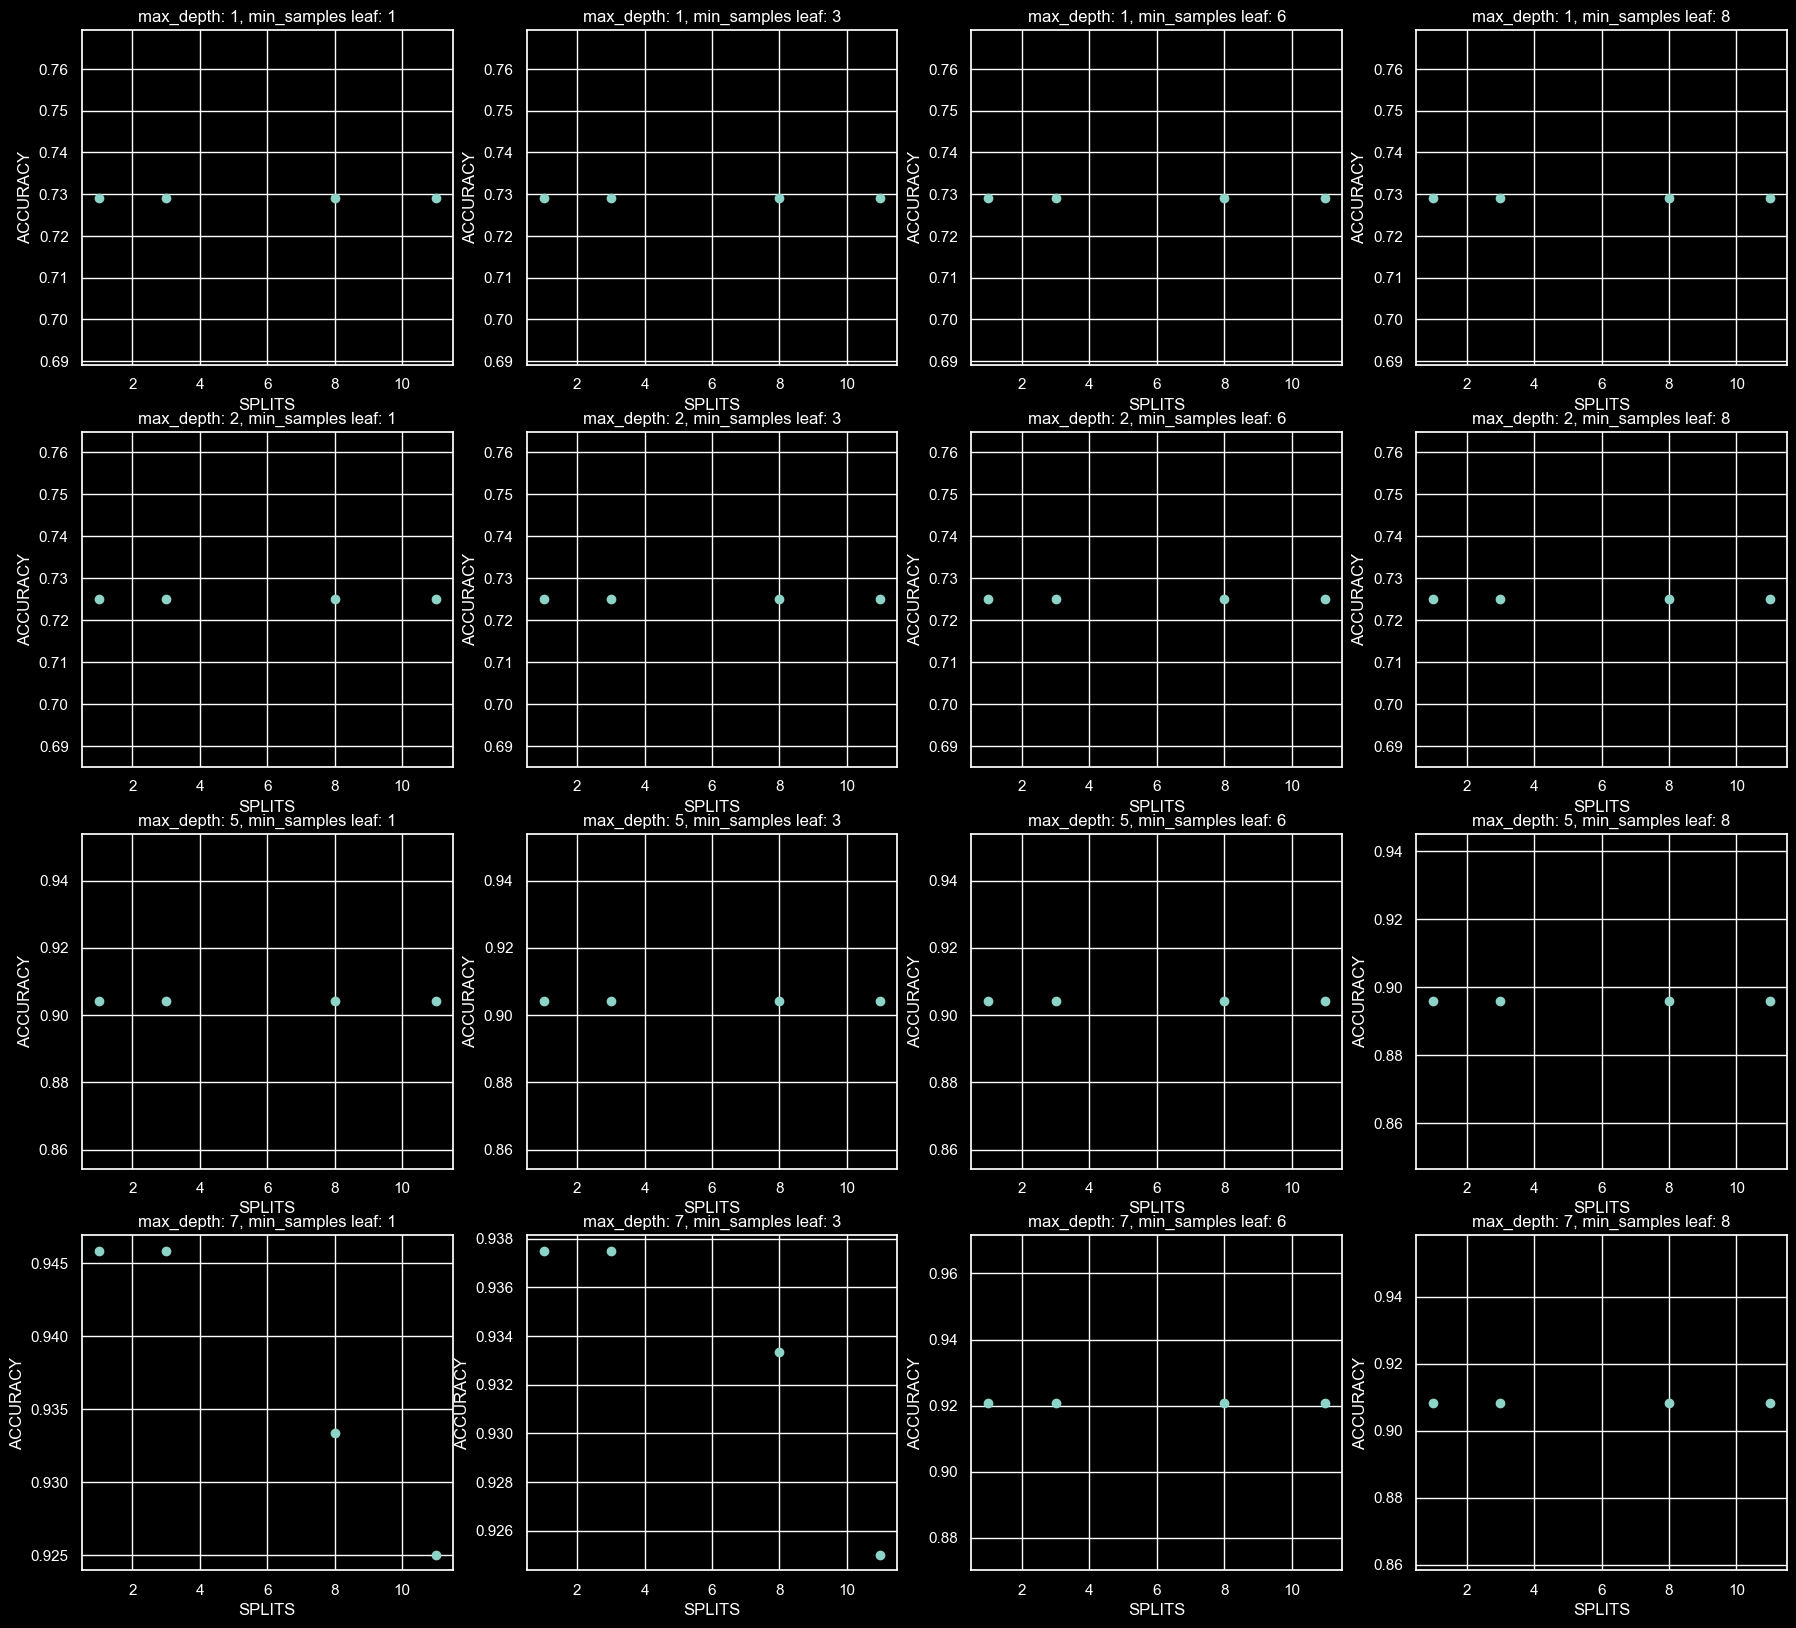

<Figure size 640x480 with 0 Axes>

In [11]:
tictactoe_path = 'datasets/tic-tac-toe-endgame.csv'
tictactoe_df = pd.read_csv(tictactoe_path)
changed_tictactoe_df = tictactoe_df.copy()


encoders = list()
features = tictactoe_df.columns

for feature in features:
    encoder = LabelEncoder()
    encoders.append(encoder)
    changed_tictactoe_df[feature] = encoder.fit_transform(tictactoe_df[feature])


new_features = changed_tictactoe_df.iloc[:, :-1]
y_target = changed_tictactoe_df.iloc[:, -1]

max_depths = [1, 2, 5, 7]
min_samples_leafs = [1, 3, 6, 8]
splits = [1, 3, 8, 11]

X_train, X_test, y_train, y_test = train_test_split(new_features, y_target)

plt.style.use('dark_background')
my_figure, axis = plt.subplots(len(max_depths), len(min_samples_leafs), figsize=(22, 20))

for j, cur_depth in enumerate(max_depths):
    for i, cur_leaf in enumerate(min_samples_leafs):

        accuracies = list()

        for split in splits:

            tree = DecisionTree(['categorical'] * new_features.shape[1], max_depth=cur_depth, min_samples_leaf=cur_leaf, min_samples_split=split)
            
            tree.fit(X_train.values, y_train.values)

            test_prediction = tree.predict(X_test.values)

            accuracy = accuracy_score(y_test, test_prediction)
            accuracies.append(accuracy)

        axis[j, i].scatter(splits, accuracies)

        axis[j, i].set_title(f'max_depth: {cur_depth}, min_samples leaf: {cur_leaf}')

        axis[j, i].set_xlabel('SPLITS')
        axis[j, i].set_ylabel('ACCURACY')

plt.show()
plt.tight_layout()

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer

import importlib
import hw2code
importlib.reload(hw2code)

datasets_with_url = {
    "mushrooms": "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
    "tic_tac_toe": "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data",
    "cars": "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",
    "nursery": "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
}

results_table = list()

for dataset_name, url in datasets_with_url.items():
    try:
        current_df = pd.read_csv(url, header=None) if dataset_name == 'mushrooms' else pd.read_csv(url)
    except Exception as error:
        raise ValueError(f"Error while loading dataset from: {url}. {str(error)}")

    target_index = 0 if dataset_name == 'mushrooms' else -1

    features = current_df.drop(current_df.columns[target_index], axis=1)
    target = current_df.iloc[:, target_index]

    features_le = features.copy()
    for col in features_le.columns:
        features_le[col] = LabelEncoder().fit_transform(features_le[col])
    
    target_le = LabelEncoder().fit_transform(target)

    ohe = OneHotEncoder(sparse_output=False)
    features_ohe = ohe.fit_transform(features_le)

    sklearn_tree = DecisionTreeClassifier()
    tree_real = DecisionTree(["real"] * features_le.shape[1])  
    tree_cat = DecisionTree(["categorical"] * features_le.shape[1])  
    tree_real_ohe = DecisionTree(["real"] * features_ohe.shape[1]) 

    accuracy_real = cross_val_score(tree_real, features_le.values, target_le, cv=10, scoring=make_scorer(accuracy_score)).mean()
    accuracy_cat = cross_val_score(tree_cat, features_le.values, target_le, cv=10, scoring=make_scorer(accuracy_score)).mean()
    accuracy_real_ohe = cross_val_score(tree_real_ohe, features_ohe, target_le, cv=10, scoring=make_scorer(accuracy_score)).mean()
    accuracy_sklearn = cross_val_score(sklearn_tree, features_le.values, target_le, cv=10, scoring=make_scorer(accuracy_score)).mean()

    results_table.append([dataset_name, accuracy_real, accuracy_cat, accuracy_real_ohe, accuracy_sklearn])

results = pd.DataFrame(results_table, columns=["Dataset", "DecisionTree_real", "DecisionTree_cat", "DecisionTree_real_ohe", "DecisionTree_sklearn"])
print(results)


       Dataset  DecisionTree_real  DecisionTree_cat  DecisionTree_real_ohe  \
0    mushrooms           0.999261          1.000000               0.999631   
1  tic_tac_toe           0.462697          0.549265               0.553520   
2         cars           0.874882          0.903300               0.846471   
3      nursery           0.901157          0.910879               0.829552   

   DecisionTree_sklearn  
0              0.961123  
1              0.788213  
2              0.862300  
3              0.798907  


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**
Нет, для разных наборов данных алгоритмы ранжируются по-разному.
Для набора mushrooms лучшим алгоритмом стал DecisionTree_cat, для tic-tac-toe - реализация из sklearn, для cars - также DecisionTree_cat, и для nursery - DecisionTree_cat. 
Я думаю, что это объясняется тем, что эффективность алгоритма зависит от того, какие признаки мы используем - категориальные или вещественные.
Алгоритм DecisionTree_cat, как и ожидалось, показывает лучшие результаты (поскольку он специально работает с категориальными признаками), а универсальные реализации (такие, как из библиотеки) лучше работают на смешанных данных, а на конкретных показывают средний результат.
На компонентну случайности можно было бы воздействовать с помощью кросс-валидации.


Вставьте что угодно, описывающее ваши впечатления от этого задания:

In [ ]:
(≧◡≦) 